In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# sharper plots
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        return X.dot(self.w_)

In [3]:
data_demo = pd.read_csv("../../_static/data/assignment8/weights_heights.csv")

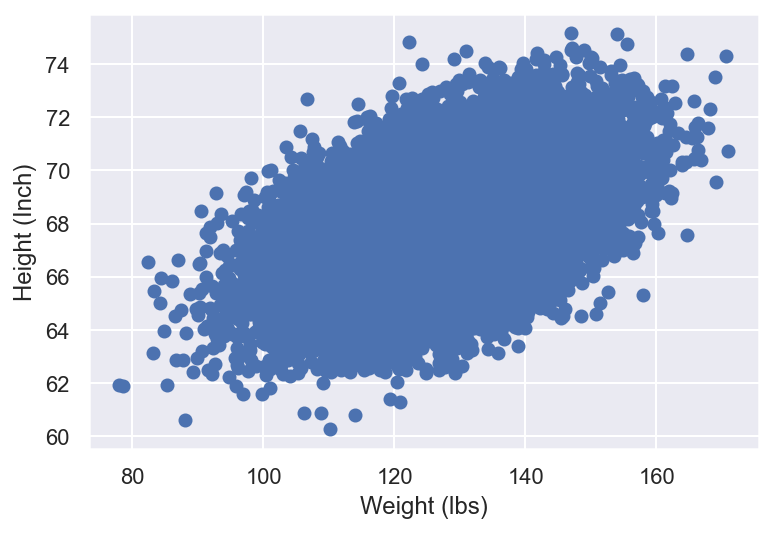

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (Inch)");

In [5]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [8]:
sgd_reg = SGDRegressor(n_iter=1)
sgd_reg.fit(X_train_scaled, y_train)

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

SGDRegressor(n_iter=1)

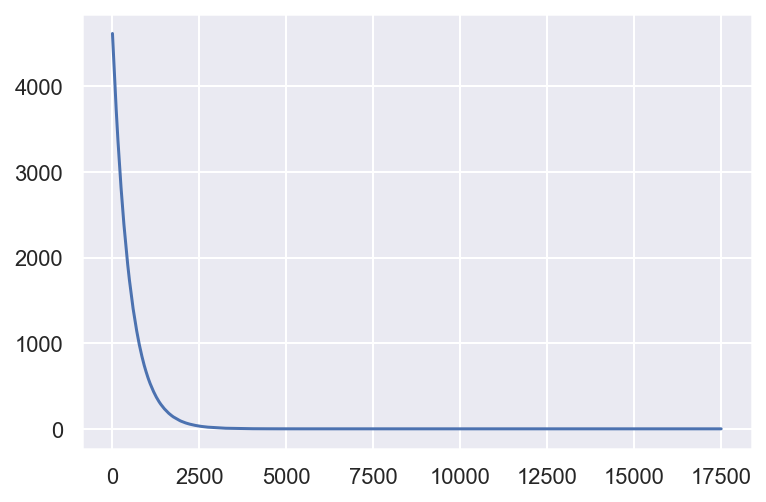

In [9]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_);

In [10]:
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643623, array([67.9898497 ,  0.94447605]))

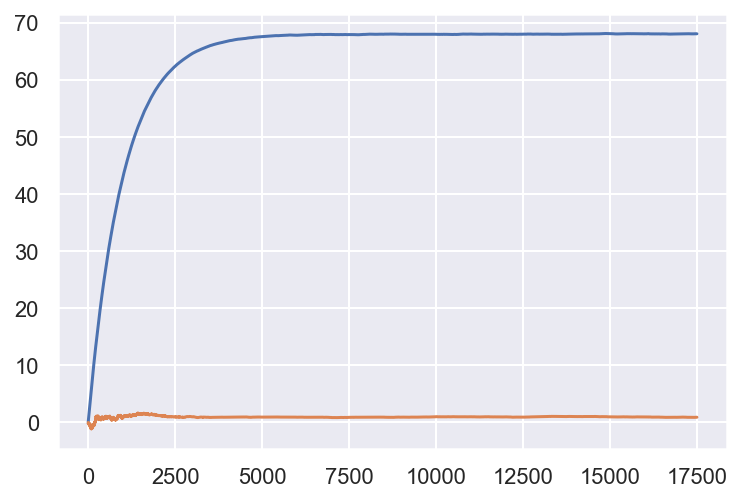

In [11]:
plt.plot(range(len(sgd_reg.weights_)), [w[0] for w in sgd_reg.weights_])
plt.plot(range(len(sgd_reg.weights_)), [w[1] for w in sgd_reg.weights_]);

In [12]:
mean_squared_error(y_valid, sgd_reg.predict(X_valid_scaled))

2.6708681207033784

In [13]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train_scaled, y_train)

lm.coef_, lm.intercept_

mean_squared_error(y_valid, lm.predict(X_valid_scaled))

2.670830767667635

In [14]:
def sigma(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [15]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):

                new_w = w.copy()

                new_w[0] += self.eta * self.C * y[i] * sigma(-y[i] * w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (
                        self.C * y[i] * X[i, j] * sigma(-y[i] * w.dot(X[i, :])) - w[j]
                    )

                w = new_w.copy()

                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)

        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self

    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])

    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5)
        # zeros can remain if pred_probs = 0.5 exactly
        signs[np.where(signs == 0)] = 1
        return signs

In [16]:
from sklearn.datasets import load_breast_cancer

In [17]:
cancer = load_breast_cancer()
# change labels in y from 0 to -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [20]:
sgd_clf = SGDClassifier(C=1, n_iter=3, eta=1e-3)
sgd_clf.fit(X_train_scaled, y_train)

  0%|                                                                                                                                | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████                                                                                | 1/3 [00:00<00:00,  2.19it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:00<00:00,  2.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]

SGDClassifier(n_iter=3)

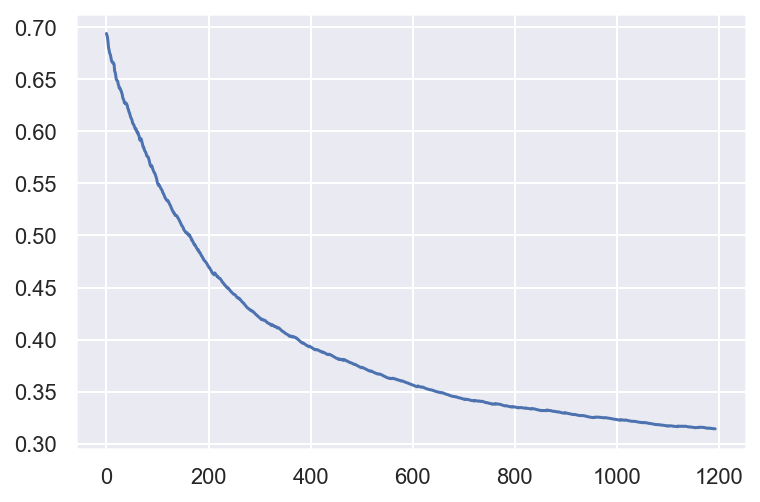

In [21]:
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

  0%|                                                                                                                               | 0/10 [00:00<?, ?it/s]

 10%|███████████▉                                                                                                           | 1/10 [00:00<00:03,  2.27it/s]

 20%|███████████████████████▊                                                                                               | 2/10 [00:00<00:03,  2.22it/s]

 30%|███████████████████████████████████▋                                                                                   | 3/10 [00:01<00:03,  2.20it/s]

 40%|███████████████████████████████████████████████▌                                                                       | 4/10 [00:01<00:02,  2.18it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 5/10 [00:02<00:02,  2.06it/s]

 60%|███████████████████████████████████████████████████████████████████████▍                                               | 6/10 [00:02<00:01,  2.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 7/10 [00:03<00:01,  2.11it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8/10 [00:03<00:00,  2.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9/10 [00:04<00:00,  2.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  1.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]

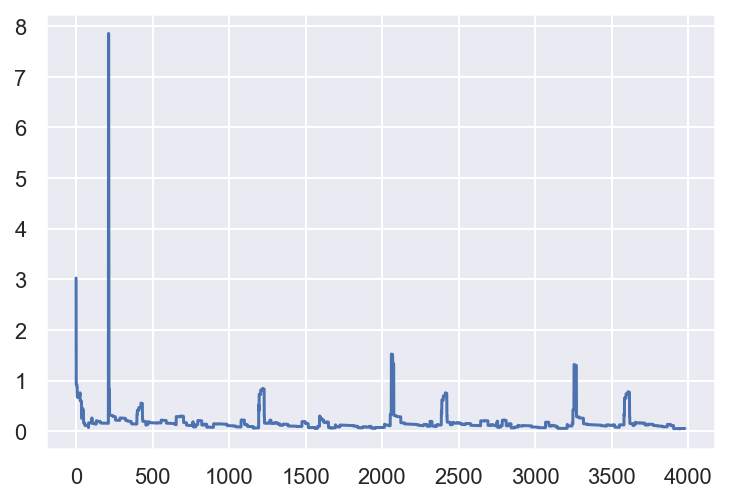

In [22]:
sgd_clf = SGDClassifier(C=1000, n_iter=10)
sgd_clf.fit(X_train_scaled, y_train)
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

In [23]:
best_w = sgd_clf.weights_[np.argmin(sgd_clf.loss_)]

In [24]:
np.min(best_w), np.max(best_w)

(-5.1073427725994245, 4.660667699024939)

In [25]:
pd.DataFrame(
    {"coef": best_w, "feat": ["intercept"] + list(cancer.feature_names)}
).sort_values(by="coef")

,coef,feat
27,-5.107343,worst concavity
11,-4.531819,radius error
22,-4.051564,worst texture
7,-3.566910,mean concavity
8,-3.543276,mean concave points
2,-3.413874,mean texture
14,-3.154584,area error
21,-2.924186,worst radius
13,-2.575289,perimeter error
24,-2.511385,worst area


In [26]:
cancer.feature_names[np.argmin(best_w) - 1]

'worst concavity'

In [27]:
log_loss(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.43441107939579693

In [28]:
roc_auc_score(y_valid, sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.9763040238450075

In [29]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)

cancer.feature_names[np.argmin(logit.coef_.flatten())]

log_loss(y_valid, logit.predict_proba(X_valid_scaled)[:, 1])

roc_auc_score(y_valid, logit.predict_proba(X_valid_scaled)[:, 1])

0.9885245901639343

In [30]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [31]:
reviews = pd.read_csv("../../_static/data/assignment5/movie_reviews_train.csv.zip")

In [32]:
reviews.head()

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


In [33]:
reviews_train, reviews_valid, y_train, y_valid = train_test_split(
    reviews["text"], reviews["label"], test_size=0.3, random_state=17
)

In [34]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(reviews_train)
X_valid = cv.transform(reviews_valid)

CPU times: user 29.8 s, sys: 784 ms, total: 30.5 s
Wall time: 30.9 s


In [35]:
X_train.shape, X_valid.shape

((106827, 2238247), (45783, 2238247))

In [36]:
%%time
logit = LogisticRegression(solver="lbfgs", random_state=17, max_iter=100)
logit.fit(X_train, y_train)
roc_auc_score(y_valid, logit.predict_proba(X_valid)[:, 1])

CPU times: user 3min 17s, sys: 40.4 s, total: 3min 57s
Wall time: 53.5 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9066679714713936

In [37]:
sgd_logit = SGDClassifier(loss="log", random_state=17, max_iter=100)

In [38]:
%%time
sgd_logit.fit(X_train, y_train)
roc_auc_score(y_valid, sgd_logit.predict_proba(X_valid)[:, 1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


CPU times: user 2.3 s, sys: 216 ms, total: 2.51 s
Wall time: 1.63 s


0.907912296097439